<a href="https://colab.research.google.com/github/mdmake/intro-to-dl-hse/blob/homeworks/training/seminars_03_fin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

from torchvision.datasets import MNIST, SVHN
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader

In [2]:
from tqdm.notebook import tqdm

# MNIST

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import clear_output
from tqdm.notebook import tqdm


sns.set_style('whitegrid')
plt.rcParams.update({'font.size': 15})


def plot_losses(train_losses, test_losses, train_accuracies, test_accuracies):
    clear_output()
    fig, axs = plt.subplots(1, 2, figsize=(13, 4))
    axs[0].plot(range(1, len(train_losses) + 1), train_losses, label='train')
    axs[0].plot(range(1, len(test_losses) + 1), test_losses, label='test')
    axs[0].set_ylabel('loss')

    axs[1].plot(range(1, len(train_accuracies) + 1), train_accuracies, label='train')
    axs[1].plot(range(1, len(test_accuracies) + 1), test_accuracies, label='test')
    axs[1].set_ylabel('accuracy')

    for ax in axs:
        ax.set_xlabel('epoch')
        ax.legend()

    plt.show()

In [12]:
def train(model, optimizer, criterion, sheduler=None):
  train_losses, train_accuracies = [], []
  test_losses, test_accuracies = [], []

  for epoch in range(1, NUM_EPOCH+1):

    # train
    model.train()
    train_loss, train_accuracy = 0, 0
    for images, labels in tqdm(train_loader, desc="training"):
      images = images.to(device)
      labels = labels.to(device)

      optimizer.zero_grad()
      # logits: batch_size x num_classes
      logits = model(images)
      loss = criterion(logits, labels)
      loss.backward()
      optimizer.step()

      train_loss += loss.item() * images.shape[0]
      train_accuracy += (logits.argmax(dim=1) == labels).sum().item()

    if sheduler is not None:
      sheduler.step()


    train_loss /= len(train_loader.dataset)
    train_accuracy /= len(train_loader.dataset)
    train_losses += [train_loss, ]
    train_accuracies += [train_accuracy, ]



    # test
    model.eval()
    test_loss, test_accuracy = 0, 0
    for images, labels in tqdm(test_loader, desc='validation'):
      images = images.to(device)
      labels = labels.to(device)

      with torch.no_grad():
        # logits: batch_size x num_classes
        logits = model(images)
        loss = criterion(logits, labels)


      test_loss += loss.item() * images.shape[0]
      test_accuracy += (logits.argmax(dim=1) == labels).sum().item()

    test_loss /= len(test_loader.dataset)
    test_accuracy /= len(test_loader.dataset)
    test_losses += [test_loss, ]
    test_accuracies += [test_accuracy, ]



    plot_losses(train_losses, test_losses, train_accuracies, test_accuracies)


In [5]:
transform = T.Compose([T.ToTensor(), T.Resize((32,32))])
train_set = MNIST('.MNIST', transform=transform, train=True, download=True)
test_set = MNIST('.MNIST', transform=transform, train=False, download=True)

In [6]:
train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
test_loader = DataLoader(test_set, batch_size=64, shuffle=False)

In [7]:
for img, lbl in test_loader:
  print(img.shape, img[0].shape, lbl[0])
  break

torch.Size([64, 1, 32, 32]) torch.Size([1, 32, 32]) tensor(7)


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [28]:
class LeNet(nn.Module):

  def __init__(self, image_channel=1):
    super().__init__()
    self.encoder = nn.Sequential(
        # 32 x 32
        nn.Conv2d(in_channels=image_channel, out_channels=6, kernel_size=5), # -> 28 x 28
        nn.Tanh(),
        nn.AvgPool2d(2), # -> 14 x 14
        nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5), # -> 10 x 10
        nn.Tanh(),
        nn.AvgPool2d(2), # -> 5 x 5
        nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5), # -> 1 x 1
    )


    self.head = nn.Sequential(
        nn.Linear(in_features=120, out_features=84),
        nn.Tanh(),
        nn.Linear(in_features=84, out_features=10)
    )

  def forward(self, x):
    # -> B x 1 x 32 x 32
    out=self.encoder(x)
    # ->B x 120 x 1 x 1
    out = out.squeeze(-1).squeeze(-1)
    # -> B x 120 x 1 x 1
    out = self.head(out)

    return out


In [9]:
#torch.randn(3,1,1).squeeze((1,2)).shape
torch.randn(3,1,1).squeeze(-1).squeeze(-1)

tensor([-0.0032,  1.1872, -0.0989])

In [13]:
NUM_EPOCH=20
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


model = LeNet().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2, momentum=0.9)
sheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCH)
criterion = nn.CrossEntropyLoss()

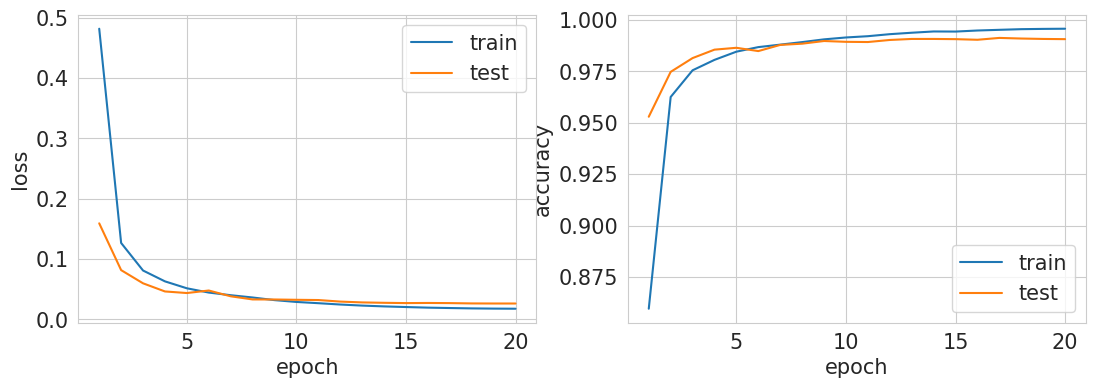

In [14]:
train(model, optimizer, criterion, sheduler)

# SVHN

In [17]:
train_set = SVHN('.SVHN', transform=None, split='train', download=True)
test_set = SVHN('.SVHN', transform=None, split='test', download=True)

Using downloaded and verified file: .SVHN/train_32x32.mat
Using downloaded and verified file: .SVHN/test_32x32.mat


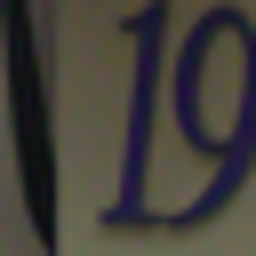

In [22]:
train_set[0][0].resize((256,256))

In [27]:
train_set = SVHN('.SVHN', transform=transform, split='train', download=True)
test_set = SVHN('.SVHN', transform=transform, split='test', download=True)
train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
test_loader = DataLoader(test_set, batch_size=64, shuffle=False)

Using downloaded and verified file: .SVHN/train_32x32.mat
Using downloaded and verified file: .SVHN/test_32x32.mat


In [29]:
NUM_EPOCH=20
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


model = LeNet(image_channel=3).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2, momentum=0.9)
sheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCH)
criterion = nn.CrossEntropyLoss()

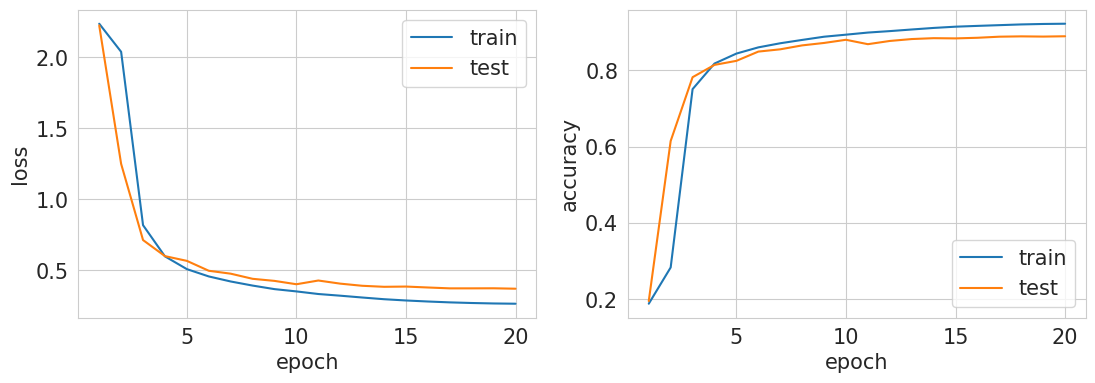

In [30]:
train(model, optimizer, criterion, sheduler)